In [1]:
import numpy as np
import pandas as pd

In [2]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow import keras 
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import LSTM, GRU, Dense, RepeatVector, TimeDistributed, Input, BatchNormalization, \
    multiply, concatenate, Flatten, Activation, dot
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

#from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

In [3]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 8)

In [4]:
with np.load('data/pol/train.npz', allow_pickle = True) as data:
    X = data['parents']
    Y = data['children']
    V = data['vocab_index'].tolist()

In [5]:
print(X.shape)
print(Y.shape)
print(V)

(19999, 1435, 24)
(19999, 1435, 24)
{'-': 0, 'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8, 'I': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'P': 14, 'Q': 15, 'R': 16, 'S': 17, 'T': 18, 'V': 19, 'W': 20, 'X': 21, 'Y': 22, 'Z': 23}


In [6]:
W = dict((i, char) for char, i in V.items())
decode_seq = lambda seq: [ ''.join([ W[i] for i in s ]) for s in np.argmax(seq, axis = 2)]

In [7]:
i = 5
print(decode_seq(X[i:i+1])[0])
print(decode_seq(Y[i:i+1])[0])

PISPIETVPVKLKPGMDGPXVKQWPLTEEKIKALVEICTEMEKEGKISKIGPENPYNTPVFAIKKKDSTKWRKLVDFRELNKRTQDFWEVQLGIPHPAGLKKKKSVTVLDVGDAYFSVPLDEDFRKYTAFTIPSINNETPGIRYQYNVLPQGWKGSPAIFQSSMTKILEPFRKQNPDIVIYQYMDDLYVGSDLEIGQHRXKIEELRQHLLRWGLTTPDKKHQKEPPFLWMGYELHPDKWTVQPIVLPEKDSWTVNDIQKLVGKLNWASQIYAGIKVKQLCKLLRGTKALTEVIPLTEEAE----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Modelis

In [28]:
n_hidden = 16

# (1, 1435)(5, 287)(7, 205)(35, 41)
n_length = 35
n_splits = X.shape[1] // n_length

n_hidden, n_length, n_splits

(16, 35, 41)

In [29]:
input_train = Input(shape=(X.shape[1], X.shape[2]), name="parent_input")
input_rand_rate = Input(shape=(), name="random_input")
output_train = Input(shape=(Y.shape[1], Y.shape[2]), name="child_output")

print(input_train)
print(input_rand_rate)
print(output_train)

KerasTensor(type_spec=TensorSpec(shape=(None, 1435, 24), dtype=tf.float32, name='parent_input'), name='parent_input', description="created by layer 'parent_input'")
KerasTensor(type_spec=TensorSpec(shape=(None,), dtype=tf.float32, name='random_input'), name='random_input', description="created by layer 'random_input'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1435, 24), dtype=tf.float32, name='child_output'), name='child_output', description="created by layer 'child_output'")


In [30]:
splits = tf.split(input_train, num_or_size_splits=n_splits, axis=1)
concat = tf.concat(splits, axis=0)
print(concat)

KerasTensor(type_spec=TensorSpec(shape=(None, 35, 24), dtype=tf.float32, name=None), name='tf.concat_2/concat:0', description="created by layer 'tf.concat_2'")


In [31]:
encoder_stack_h, encoder_last_h = GRU(
    n_hidden, dropout = 0.01, recurrent_dropout = 0.01,
    return_sequences = True, return_state = True)(concat)
print(encoder_stack_h)
print(encoder_last_h)

KerasTensor(type_spec=TensorSpec(shape=(None, 35, 16), dtype=tf.float32, name=None), name='gru_2/transpose_1:0', description="created by layer 'gru_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 16), dtype=tf.float32, name=None), name='gru_2/while:4', description="created by layer 'gru_2'")


In [32]:
encoder_last_h = BatchNormalization(momentum = 0.6)(encoder_last_h)
decoder_input = RepeatVector(concat.shape[1])(encoder_last_h)
print(decoder_input)

KerasTensor(type_spec=TensorSpec(shape=(None, 35, 16), dtype=tf.float32, name=None), name='repeat_vector_1/Tile:0', description="created by layer 'repeat_vector_1'")


In [33]:
decoder_stack_h = GRU(n_hidden, dropout = 0.01, recurrent_dropout = 0.01,
 return_state = False, return_sequences = True)(
 decoder_input, initial_state = encoder_last_h)
print(decoder_stack_h)

KerasTensor(type_spec=TensorSpec(shape=(None, 35, 16), dtype=tf.float32, name=None), name='gru_3/transpose_1:0', description="created by layer 'gru_3'")


In [34]:
attention = dot([decoder_stack_h, encoder_stack_h], axes = [2, 2])
attention = Activation('softmax')(attention)
print(attention)

KerasTensor(type_spec=TensorSpec(shape=(None, 35, 35), dtype=tf.float32, name=None), name='activation_1/Softmax:0', description="created by layer 'activation_1'")


In [35]:
class RandomDropout(keras.layers.Layer):
    
    def call(self, inputs, rate):
        return tf.nn.dropout(inputs, rate=rate[0])
    

In [36]:
context = dot([attention, encoder_stack_h], axes = [2,1])
context = BatchNormalization(momentum = 0.6)(context)
context = RandomDropout()(context, input_rand_rate)
print(context)

KerasTensor(type_spec=TensorSpec(shape=(None, 35, 16), dtype=tf.float32, name=None), name='random_dropout_1/dropout/Mul:0', description="created by layer 'random_dropout_1'")


In [37]:
decoder_combined_context = concatenate([context, decoder_stack_h])
print(decoder_combined_context)

KerasTensor(type_spec=TensorSpec(shape=(None, 35, 32), dtype=tf.float32, name=None), name='concatenate_1/concat:0', description="created by layer 'concatenate_1'")


In [38]:
out = TimeDistributed(Dense(concat.shape[2], activation = "softmax"))(decoder_combined_context)
print(out)

KerasTensor(type_spec=TensorSpec(shape=(None, 35, 24), dtype=tf.float32, name=None), name='time_distributed_1/Reshape_1:0', description="created by layer 'time_distributed_1'")


In [39]:
back_splits = tf.split(out, num_or_size_splits=n_splits, axis=0)
back_concat = tf.concat(back_splits, axis=1)
print(back_concat)

KerasTensor(type_spec=TensorSpec(shape=(None, 1435, 24), dtype=tf.float32, name=None), name='tf.concat_3/concat:0', description="created by layer 'tf.concat_3'")


In [40]:
model = Model(inputs = [input_train, input_rand_rate], outputs = back_concat)
opt = keras.optimizers.Adam(learning_rate = 0.01, clipnorm = 1, amsgrad = True)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 parent_input (InputLayer)      [(None, 1435, 24)]   0           []                               
                                                                                                  
 tf.split_2 (TFOpLambda)        [(None, 35, 24),     0           ['parent_input[0][0]']           
                                 (None, 35, 24),                                                  
                                 (None, 35, 24),                                                  
                                 (None, 35, 24),                                                  
                                 (None, 35, 24),                                                  
                                 (None, 35, 24),                                            

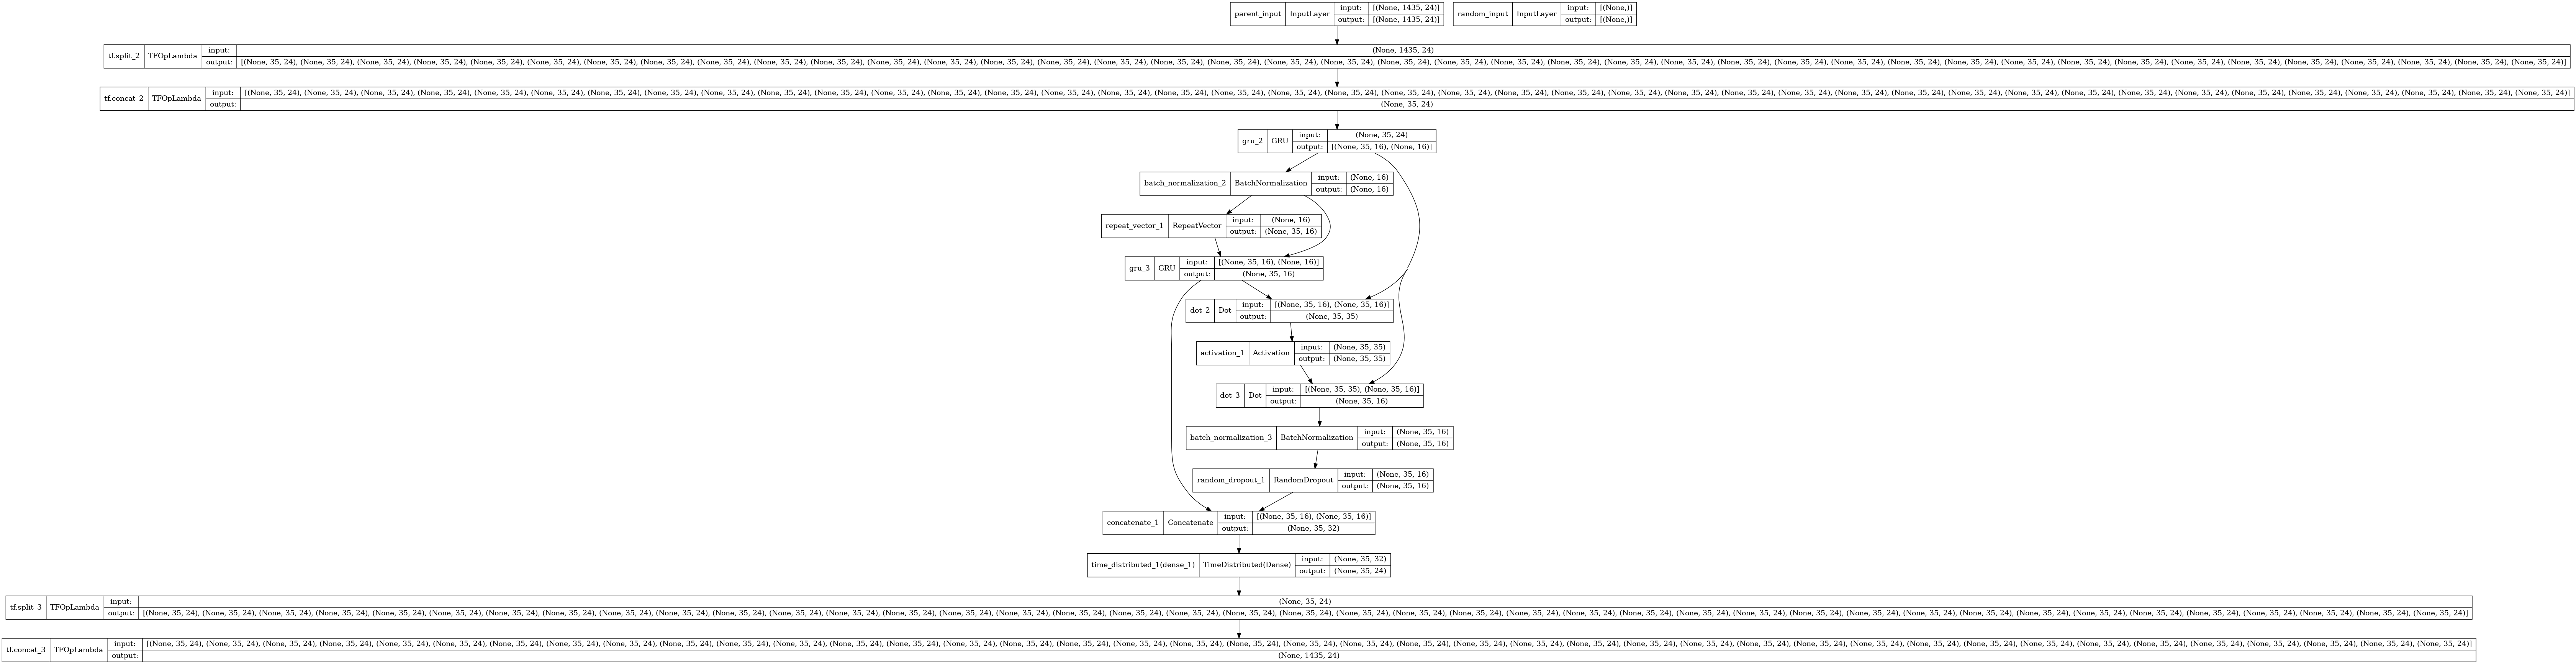

In [41]:
keras.utils.plot_model(model, to_file = 'model_plot.png', show_shapes = True, show_layer_names = True)

## Train

In [46]:
batch_size = 64      # Batch size for training.
patience = 25        # Patience for EarlyStop
epochs = 500         # Number of epochs to train for.
rand_rate = np.full((len(X)), 0.0)
rand_rate.shape

(19999,)

In [47]:
es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = patience, restore_best_weights = True)
history = model.fit([ X, rand_rate ], Y, 
                    validation_split = 0.2, 
                    epochs = epochs, verbose = 1, callbacks = [ es ], 
                    batch_size = batch_size)

# train_mae = history.history['accuracy']
# valid_mae = history.history['val_accuracy']

Epoch 1/500
250/250 [==============================] - 29s 117ms/step - loss: 0.8872 - accuracy: 0.7777 - val_loss: 0.7872 - val_accuracy: 0.8049
Epoch 2/500
250/250 [==============================] - 30s 118ms/step - loss: 0.8876 - accuracy: 0.7778 - val_loss: 0.7837 - val_accuracy: 0.8081
Epoch 3/500
250/250 [==============================] - 29s 116ms/step - loss: 0.8855 - accuracy: 0.7786 - val_loss: 0.7833 - val_accuracy: 0.8086
Epoch 4/500
250/250 [==============================] - 30s 119ms/step - loss: 0.8914 - accuracy: 0.7766 - val_loss: 0.7929 - val_accuracy: 0.8045
Epoch 5/500
250/250 [==============================] - 29s 116ms/step - loss: 0.8883 - accuracy: 0.7778 - val_loss: 0.7831 - val_accuracy: 0.8082
Epoch 6/500
250/250 [==============================] - 30s 119ms/step - loss: 0.8854 - accuracy: 0.7786 - val_loss: 0.7847 - val_accuracy: 0.8085
Epoch 7/500
250/250 [==============================] - 29s 116ms/step - loss: 0.8869 - accuracy: 0.7782 - val_loss: 0.7810 -

Epoch 57/500
250/250 [==============================] - 30s 118ms/step - loss: 0.8826 - accuracy: 0.7809 - val_loss: 0.7798 - val_accuracy: 0.8098
Epoch 58/500
250/250 [==============================] - 29s 116ms/step - loss: 0.8822 - accuracy: 0.7810 - val_loss: 0.7780 - val_accuracy: 0.8087
Epoch 59/500
250/250 [==============================] - 30s 118ms/step - loss: 0.8815 - accuracy: 0.7814 - val_loss: 0.7766 - val_accuracy: 0.8116
Epoch 60/500
250/250 [==============================] - 29s 116ms/step - loss: 0.8831 - accuracy: 0.7809 - val_loss: 0.7789 - val_accuracy: 0.8100
Epoch 61/500
250/250 [==============================] - 29s 118ms/step - loss: 0.8808 - accuracy: 0.7814 - val_loss: 0.7766 - val_accuracy: 0.8087
Epoch 62/500
250/250 [==============================] - 29s 116ms/step - loss: 0.8812 - accuracy: 0.7814 - val_loss: 0.7795 - val_accuracy: 0.8088
Epoch 63/500
250/250 [==============================] - 30s 118ms/step - loss: 0.8810 - accuracy: 0.7815 - val_loss: 0

250/250 [==============================] - 29s 118ms/step - loss: 0.8828 - accuracy: 0.7826 - val_loss: 0.7693 - val_accuracy: 0.8168
Epoch 113/500
250/250 [==============================] - 29s 116ms/step - loss: 0.8765 - accuracy: 0.7848 - val_loss: 0.7773 - val_accuracy: 0.8149
Epoch 114/500
250/250 [==============================] - 30s 119ms/step - loss: 0.8851 - accuracy: 0.7817 - val_loss: 0.7768 - val_accuracy: 0.8127
Epoch 115/500
250/250 [==============================] - 29s 116ms/step - loss: 0.8793 - accuracy: 0.7837 - val_loss: 0.7756 - val_accuracy: 0.8135
Epoch 116/500
250/250 [==============================] - 29s 118ms/step - loss: 0.8801 - accuracy: 0.7835 - val_loss: 0.7704 - val_accuracy: 0.8156
Epoch 117/500
250/250 [==============================] - 29s 117ms/step - loss: 0.8759 - accuracy: 0.7850 - val_loss: 0.7785 - val_accuracy: 0.8159
Epoch 118/500
250/250 [==============================] - 30s 118ms/step - loss: 0.8784 - accuracy: 0.7838 - val_loss: 0.7709 -

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



250/250 [==============================] - 29s 116ms/step - loss: 0.8775 - accuracy: 0.7848 - val_loss: 0.7728 - val_accuracy: 0.8168
Epoch 165/500
250/250 [==============================] - 30s 118ms/step - loss: 0.8773 - accuracy: 0.7850 - val_loss: 0.7702 - val_accuracy: 0.8163
Epoch 166/500
250/250 [==============================] - 29s 116ms/step - loss: 0.8753 - accuracy: 0.7857 - val_loss: 0.7673 - val_accuracy: 0.8160
Epoch 167/500
250/250 [==============================] - 30s 118ms/step - loss: 0.8815 - accuracy: 0.7834 - val_loss: 0.7704 - val_accuracy: 0.8156
Epoch 168/500
250/250 [==============================] - 29s 116ms/step - loss: 0.8848 - accuracy: 0.7820 - val_loss: 0.7716 - val_accuracy: 0.8160
Epoch 169/500
250/250 [==============================] - 30s 118ms/step - loss: 0.8826 - accuracy: 0.7831 - val_loss: 0.7722 - val_accuracy: 0.8151
Epoch 170/500
250/250 [==============================] - 29s 116ms/step - loss: 0.8786 - accuracy: 0.7846 - val_loss: 0.7695 -

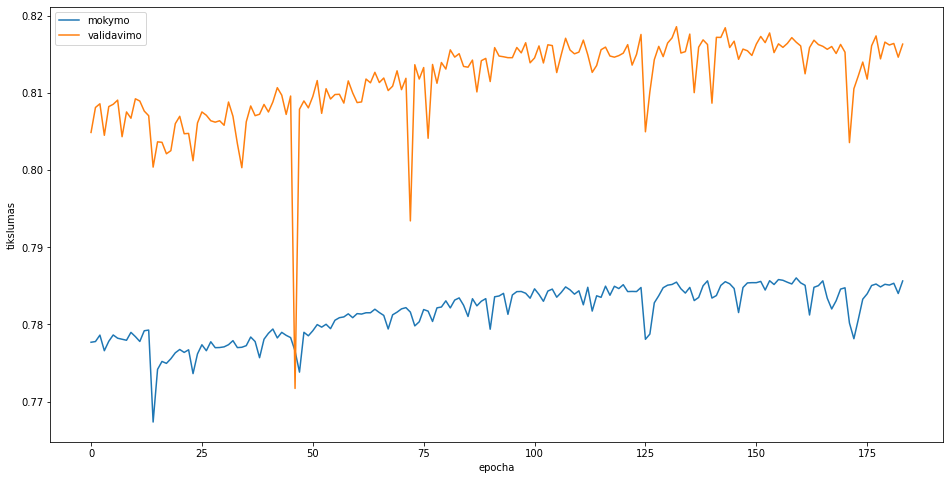

In [48]:
plt.plot(history.history['accuracy'], label = 'mokymo')
plt.plot(history.history['val_accuracy'], label = 'validavimo')
plt.ylabel('tikslumas')
plt.xlabel('epocha')
plt.legend()
plt.show()

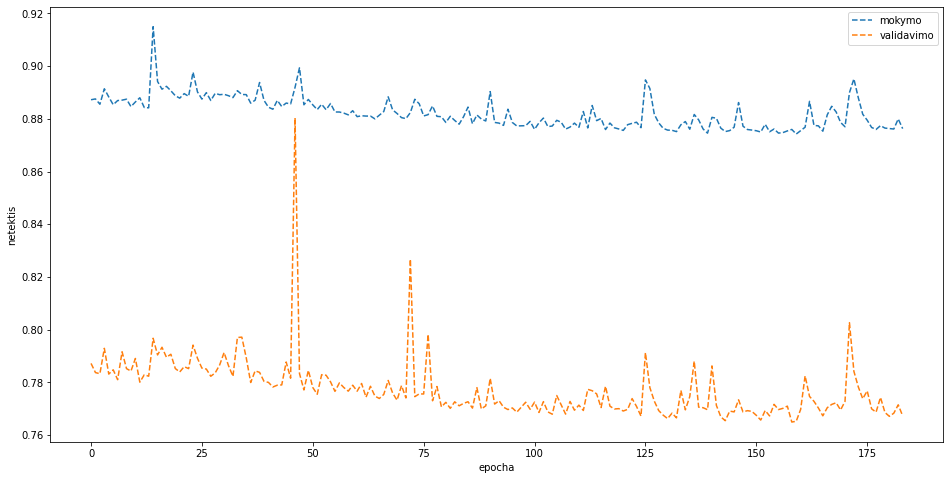

In [49]:
plt.plot(history.history['loss'], '--', label = 'mokymo')
plt.plot(history.history['val_loss'], '--', label = 'validavimo')
plt.ylabel('netektis')
plt.xlabel('epocha')
plt.legend()
plt.show()